In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from CTRNN import CTRNN
from pathos.multiprocessing import ProcessPool
import time
import networkx as nx
import itertools
from networkx.drawing.nx_agraph import to_agraph 
from numpy import cov
from scipy.stats import pearsonr
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import precision_recall_fscore_support


Necessary functions

In [2]:
class environment:
        def __init__(self, data, answers, active_perception, net_size):
            self.stimuli = data
            self.answers = answers
            self.active_perception = active_perception
            self.net_size = net_size
            self.current_stimulus = None 

        def step(self,action,done=False):
            if done:#np.nanargmax(action) == self.net_size-2: ## wants to respond
                reward = 1-np.round(abs(self.answers[self.current_stimulus]-action[self.net_size-1]))#(-abs(self.answers[self.current_stimulus]-action[self.net_size-1]))+1 # from 0 to 1
                next_observation = self.stimuli[self.current_stimulus]
            else:
                reward = 0
                if not self.active_perception or np.nanargmax(action) == self.net_size-2 or np.nanargmax(action) == self.net_size-1:
                    next_observation = self.stimuli[self.current_stimulus] # show the whole picture again
               
                else:
                    zoom_index = np.nanargmax(action)
                    zoomed_observation = self.stimuli[self.current_stimulus].flatten()[zoom_index]
                    next_observation = np.zeros(self.stimuli[self.current_stimulus].shape)+zoomed_observation

            return reward, next_observation, done
        def choose_stimulus(self, n=None):
            if n:
                self.current_stimulus = n 
            else:
                self.current_stimulus = np.random.choice(range(len(self.stimuli)))
            # starting observation will be all zeros
            return self.stimuli[self.current_stimulus]

In [3]:
def create_stimuli(n, shape, obj_types):
    dataset = []
    answers = []
    # all positive (same)
    for _ in range(n//2):
        stimulus = np.zeros(shape)
        object_1 = object_2 = np.random.choice(obj_types)
        while True:
            o1_x = np.random.choice(range(shape[0]))
            o1_y = np.random.choice(range(shape[1]))
            o2_x = np.random.choice(range(shape[0]))
            o2_y = np.random.choice(range(shape[1]))
            if [o1_x,o1_y] != [o2_x,o2_y]:
                break
        stimulus[o1_x,o1_y] = object_1
        stimulus[o2_x,o2_y] = object_2
        dataset.append(stimulus)
        #dataset.append(np.zeros((2,2))+1)
        answers.append(1)
        
    # all negative (different)
    for _ in range(n//2):
        stimulus = np.zeros(shape)
        while True:
            object_1 = np.random.choice(obj_types)        
            object_2 = np.random.choice(obj_types)
            if object_1 != object_2:
                break
        while True:
            o1_x = np.random.choice(range(shape[0]))
            o1_y = np.random.choice(range(shape[1]))
            o2_x = np.random.choice(range(shape[0]))
            o2_y = np.random.choice(range(shape[1]))
            if [o1_x,o1_y] != [o2_x,o2_y]:
                break
        stimulus[o1_x,o1_y] = object_1
        stimulus[o2_x,o2_y] = object_2
        dataset.append(stimulus)
        #dataset.append(np.zeros((2,2))+2)
        answers.append(0)
    return dataset, answers

In [4]:
def create_individual(genes, net_size):
    # Net size is fixed at 10
    step_size = 0.01
    network = CTRNN(size=net_size,step_size=step_size)
    network.taus = genes[0:net_size]
    network.biases = genes[net_size:net_size*2]
    network.weights = genes[net_size*2:].reshape((net_size,net_size))
    network.randomize_outputs(0.1,0.9)
    return network

Behavioral experiment

In [5]:
def simulation(agent_genes,sample_size,active_perception,stim,net_size=6,max_steps=8,step_size=0.01):
    agent = create_individual(agent_genes,net_size)
    data, answers = create_stimuli(sample_size,(2,2),stim)
    env = environment(data, answers, active_perception, net_size) # have to change this for the experiments with w/o active perception
    rewards = []
    actions = []
    stimuli = []
        # evaluate on the basis of sample_size randomly chosen stimuli
    for _ in range(sample_size):
        reward = 0
        observation = env.choose_stimulus(_)
        agent.randomize_states(0.01,0.99)
        observation = np.concatenate((observation.flatten(),np.zeros((2,))+0.001))
        done = False
        actions_stim = []
        stimuli.append(observation)
        for j in range(max_steps):
            if j >= max_steps-2:
                done = True
            agent.euler_step(observation)
            for m in range(int(1//step_size)):
                agent.euler_step(observation) 
            action = agent.outputs
            actions_stim.append(action)
            if np.sum(np.isnan(action)) != 0:
                reward = -1000
                break
            rew, observation, done = env.step(action, done)
            # add empty inputs for 2 "motor" neurons
            observation = np.concatenate((observation.flatten(),np.zeros((2,))+0.01))
            reward += rew
                # no punishment if agent did not choose anything and reached max number of steps
            if done:
                break
        actions.append(actions_stim)
        rewards.append(reward)
        
    return [actions, rewards, stimuli]


VisualizatFunctions for visualization and behavioral tests

In [1018]:
def visualize_dynamics(agent_genes,active_perception,stimulus,net_size=6,max_steps=8,step_size=0.01):
    agent = create_individual(agent_genes,net_size)
    activations = []    
    agent.randomize_states(0.01,0.99)
    observation = np.concatenate((stimulus,np.zeros((2,))+0.001))
    print(observation)
    for j in range(max_steps-1):
        agent.euler_step(observation)
        activations.append(agent.outputs)
        for m in range(int(1//step_size)):
            agent.euler_step(observation) 
            activations.append(agent.outputs)
    activations = np.array(activations)
    plt.figure()
    plt.plot(np.arange(0,max_steps-1,0.01),activations)
    plt.title('Activations for stimulus: ' + str(stimulus))
    plt.xlabel('Time')
    plt.ylabel('Activation')
    plt.legend(['s1', 's2', 's3', 's4', 'i', 'm'], loc='lower left')
    plt.show()
    return activations 
        

In [6]:
def transform_actions(action_list,max_steps):
    new_actions = []
    for trial in range(len(action_list)):
        actions_trial = []
        for i in range(max_steps-1):
            if i == max_steps-2:
                actions_trial.append(action_list[trial][i][-1])
            else:
                actions_trial.append(np.nanargmax(action_list[trial][i]))
        new_actions.append(actions_trial)
    return np.array(new_actions)
        

In [563]:
def visualize_ctrnn(ctrnn_genes, scale = 1):
    
    def complete_graph_from_list(L, create_using=None):
        G = nx.empty_graph(0,None)
        G = G.to_directed()
        if len(L)>1:
            if G.is_directed():
                edges = itertools.product(L, repeat=2)
            else:
                edges = itertools.product(L, repeat=2)
            G.add_edges_from(edges)
        return G

    S = complete_graph_from_list(["s1", "s2", "s3", "s4", "i", "m"])
    
    e_ix = 0
    for e in S.edges():
        S[str(e[0])][str(e[1])]['weight']=best_agent[12+e_ix]
        e_ix += 1
        
    weights_array = ctrnn_genes[12:48].reshape(6,6) * scale
    node_colors = np.diagonal(weights_array)
    #edge_colors = np.delete(weights_array,range(0,weights_array.shape[0]**2,(weights_array.shape[0]+1))).reshape(weights_array.shape[0],(weights_array.shape[1]-1)).flatten()

    pos = nx.shell_layout(S)

    nx.draw_networkx_nodes(S, pos, node_size=700, node_color = node_colors,cmap=plt.cm.bwr)

    # edges
    nx.draw_networkx_edges(S, pos, edgelist=S.edges(),width=weights_array.flatten()*3,
                          arrowstyle="-|>", edge_cmap=plt.cm.coolwarm, connectionstyle='arc3,rad=0.6', arrowsize=25, 
                           edge_color=weights_array.flatten())#np.array(best_agent[12:]<0).astype(int))

    # labels
    nx.draw_networkx_labels(S, pos, font_size=20, font_family="sans-serif")

    plt.axis("off")
    plt.show()

In [8]:
def object_positions(stimuli):
    object_locations = np.argwhere(np.absolute(stimuli)>0.01)[:,1].reshape((int(np.argwhere(np.absolute(stimuli)>0.01)[:,1].size/2),2))
    return object_locations


In [1013]:
def correct_and_looked(stimuli, actions, rewards, max_steps=8):
    actions = np.array(actions)
    rewards = np.array(rewards)
    #nor = np.logical_not(np.logical_xor(looked_at_objects(actions,stimuli)[2],rewards==1.0))
    
    #index = np.sum(nor)/nor.size
    corr = pearsonr(looked_at_objects(actions,stimuli,max_steps)[2],rewards==1.0)
    covr = cov(looked_at_objects(actions,stimuli,max_steps)[2],rewards==1.0)
    return [corr, covr]
    

In [1002]:
def looked_at_objects(actions, stimuli, max_steps = 8):
    actions = np.array(actions)
    transformed_actions = transform_actions(actions,max_steps)
    object_locations = object_positions(stimuli)
    obj_1 = np.sum(np.equal(transformed_actions,object_locations[:,0].reshape(500,1))>0, axis=1)
    obj_2 = np.sum(np.equal(transformed_actions,object_locations[:,1].reshape(500,1))>0, axis=1)
    looked_at_both = np.logical_and(obj_2>0,obj_1>0)
    return [obj_1,obj_2,looked_at_both]


In [1006]:
def response_distribution(actions, rewards, max_steps = 8):
    transformed_actions = transform_actions(actions,max_steps)
    y_pred = transformed_actions[:,max_steps-2]>0.5
    y_pred = y_pred.astype(int)
    y_true = []
    for i in range(len(y_pred)):
        if rewards[i] == 1.0:
            y_true.append(y_pred[i])
        elif rewards[i] == 0.0:
            y_true.append(1.0-y_pred[i])
            
    same_prop = sum(y_pred)/transformed_actions[:,max_steps-2].size
    fresult = precision_recall_fscore_support(y_true,y_pred)
    return [same_prop, 1-same_prop, fresult, y_true]


In [12]:
def reconstruction_analysis(input_size, output_size, inputs, outputs):
    categorical_resp = keras.utils.to_categorical(outputs)
    model = Sequential()
    model.add(Dense(5, input_dim=input_size, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(output_size, activation='softmax')) #response - 1 or 0
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(inputs, categorical_resp, epochs=1000, batch_size=64, verbose=0)
    return history.history['accuracy'][-1]

In [1007]:
def reconstruction_analysis_final_response(actions, rewards, max_steps=8):
    results = {}
    
    baseline = max(response_distribution(actions, rewards)[0:2])
    for start_neuron in range(6):
        for end_neuron in range(start_neuron+1,6):
            for start_t in range(max_steps-1):
                for end_t in range(start_t+1,max_steps-1):
                    transformed_actions = transform_actions(actions,max_steps)
                    responses = (transformed_actions[:,max_steps-2]>0.5).astype(int)
                    responses = responses.reshape((500,1))
                    actions = np.array(actions)
                    inputs = actions[:,start_t:end_t,start_neuron:end_neuron]
                    inputs = inputs.reshape((inputs.shape[0],inputs.shape[1]*inputs.shape[2]))
                    result = reconstruction_analysis(inputs.shape[1], 2, inputs, responses)
                    normalized_result = (result-baseline)/(1.00-baseline)
                    results['start_n: ' + str(start_neuron) + ', end_n: ' + str(end_neuron) +
                            ', start_t: ' + str(start_t) + ', end_t: ' + str(end_t)] = normalized_result
                    print('start neuron: ' + str(start_neuron) + ', end neuron: ' + str(end_neuron) +
                            ', start time: ' + str(start_t) + ', end time: ' + str(end_t) + ', result: ' + str(normalized_result))
    return results


In [1008]:
def reconstruction_analysis_stimulus(actions, stimuli, max_steps=8):
    results = {}
    baseline = 0.5
    y_true = response_distribution(actions, rewards)[3]
    y_true = np.array(y_true)
    y_true = y_true.reshape((500,1))
    transformed_actions = transform_actions(actions,max_steps)
    actions = np.array(actions)
    for start_neuron in range(6):
        for end_neuron in range(start_neuron+1,6):
            for start_t in range(7):
                for end_t in range(start_t+1,max_steps-1):
                    inputs = actions[:,start_t:end_t,start_neuron:end_neuron]
                    inputs = inputs.reshape((inputs.shape[0],inputs.shape[1]*inputs.shape[2]))
                    result = reconstruction_analysis(inputs.shape[1], 2, inputs, y_true)
                    normalized_result = (result-baseline)/(1.00-baseline)
                    results['start_n: ' + str(start_neuron) + ', end_n: ' + str(end_neuron) +
                            ', start_t: ' + str(start_t) + ', end_t: ' + str(end_t)] = normalized_result
                    print('start neuron: ' + str(start_neuron) + ', end neuron: ' + str(end_neuron) +
                            ', start time: ' + str(start_t) + ', end time: ' + str(end_t) + ', result: ' + str(normalized_result))
    return results

In [168]:
def interpolation_test(best_agent, active_perception, train_stims, max_steps = 8, net_size = 6):
    minim = np.min(train_stims)
    maxim = np.max(train_stims)
    
    interpolation_stims = np.linspace(minim,maxim,20)
    print("Stimuli for interpolation test:")
    print(interpolation_stims)
    
    actions,inter_rewards,stimuli = simulation(best_agent,1000,active_perception,
         interpolation_stims,net_size,max_steps,step_size=0.01)
    
    print("Interpolation test: " + str(np.mean(inter_rewards)))
    print(response_distribution(actions,inter_rewards))
    
    return [np.mean(inter_rewards),response_distribution(actions,inter_rewards)]


In [1009]:
def extrapolation_test(best_agent, active_perception, train_stims, max_steps = 8, net_size = 6):
    first = np.max(train_stims)
    difference = train_stims[1]-train_stims[0]
    
    stims_list = []
    performance = []
    precision_recall_f = []
    
    # looking at the original accuracy
    stims_list.append(train_stims)
    actions,rewards,stimuli = simulation(best_agent,100,active_perception,
             train_stims,net_size,max_steps,step_size=0.01)
    print("Train stimuli: " + str(train_stims) + ", performance: " + str(np.mean(rewards)))
    performance.append(np.mean(rewards))
    precision_recall_f.append(response_distribution(actions,rewards))
    
    
    #20 tests
    for i in range(20):
        
        second = first + difference
        stims = [first, second]
    
        actions,rewards,stimuli = simulation(best_agent,100,active_perception,
             stims,net_size,max_steps,step_size=0.01)
        
        stims_list.append(stims)
        performance.append(np.mean(rewards))
        
        try:
            precision_recall_f.append(response_distribution(actions,rewards))
        except:
            continue
        
        print("Stimuli: " + str(stims) + ", performance: " + str(np.mean(rewards)))
        
        first += difference
        
    return [stims_list, performance, precision_recall_f]


In [890]:
def visualize_reconstruction(rec_data, time_max = 7):

    data_vis = []
    for start_neuron in range(5):
        data_cur = []
        end_neuron = start_neuron+1
        for start_time in range(time_max-1):
            end_time = start_time+1
            data_cur.append(rec_data['start_n: {}, end_n: {}, start_t: {}, end_t: {}'.format(start_neuron,end_neuron,
                                                                                                start_time,end_time)])
        data_vis.append(data_cur)

    for start_neuron in range(4):
        data_cur = []
        end_neuron = start_neuron+2
        for start_time in range(time_max-1):
            end_time = start_time+1
            data_cur.append(rec_data['start_n: {}, end_n: {}, start_t: {}, end_t: {}'.format(start_neuron,end_neuron,
                                                                                                 start_time,end_time)])

        data_vis.append(data_cur)


    for start_neuron in range(3):
        data_cur = []
        end_neuron = start_neuron+3
        for start_time in range(time_max-1):
            end_time = start_time+1
            data_cur.append(rec_data['start_n: {}, end_n: {}, start_t: {}, end_t: {}'.format(start_neuron,end_neuron,
                                                                                                 start_time,end_time)])

        data_vis.append(data_cur)

    for start_neuron in range(2):
        data_cur = []
        end_neuron = start_neuron+4
        for start_time in range(time_max-1):
            end_time = start_time+1
            data_cur.append(rec_data['start_n: {}, end_n: {}, start_t: {}, end_t: {}'.format(start_neuron,end_neuron,
                                                                                                 start_time,end_time)])

        data_vis.append(data_cur)

    for start_neuron in range(1):
        data_cur = []
        end_neuron = start_neuron+5
        for start_time in range(time_max-1):
            end_time = start_time+1
            data_cur.append(rec_data['start_n: {}, end_n: {}, start_t: {}, end_t: {}'.format(start_neuron,end_neuron,
                                                                                                 start_time,end_time)])

        data_vis.append(data_cur)

    data_vis = np.array(data_vis)

    plt.figure()
    plt.plot(data_vis.T)
    plt.xlabel('Time')
    plt.ylabel('Reconstruction performance')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               labels=['s1','s2','s3','s4','i', 's1+s2', 's2+s3', 's3+s4', 's4+i', 's1+s2+s3', 's2+s3+s4', 's3+s4+i',
               's1+s2+s3+s4', 's2+s3+s4+i', 's1+s2+s3+s4+i'])
    plt.show()


Analysis

In [990]:
data = pd.read_pickle(r'CTRNN_results/new/w1m005step9c0.pkl')
# conditions
data[4]

[True, [1, 2]]

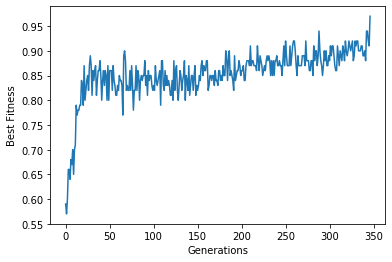

In [991]:
plt.figure()
plt.plot(data[0])
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
#plt.legend(['best fitness', 'avg. fitness'])
plt.show()

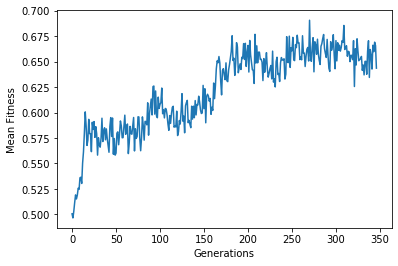

In [992]:
plt.figure()
plt.plot(data[1])
plt.xlabel('Generations')
plt.ylabel('Mean Fitness')
#plt.legend(['best fitness', 'avg. fitness'])
plt.show()

In [1010]:
best_agent = data[3]

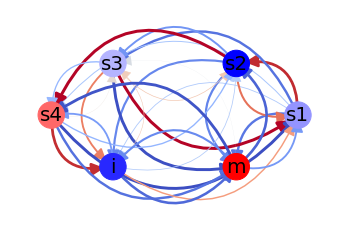

In [1011]:
visualize_ctrnn(best_agent)

In [995]:
actions,rewards,stimuli = simulation(best_agent,500,data[4][0],
         data[4][1],net_size=6,max_steps=9,step_size=0.01)
stimuli = np.array(stimuli)

In [996]:
np.mean(rewards)

0.848

In [997]:
stimuli

array([[2.e+00, 0.e+00, 1.e+00, 0.e+00, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 0.e+00, 0.e+00, 1.e-03, 1.e-03],
       [1.e+00, 0.e+00, 0.e+00, 1.e+00, 1.e-03, 1.e-03],
       ...,
       [0.e+00, 1.e+00, 2.e+00, 0.e+00, 1.e-03, 1.e-03],
       [1.e+00, 0.e+00, 0.e+00, 2.e+00, 1.e-03, 1.e-03],
       [1.e+00, 0.e+00, 2.e+00, 0.e+00, 1.e-03, 1.e-03]])

In [1004]:
transformed_actions = transform_actions(actions,9)

In [958]:
transformed_actions

array([[3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        0.87172393],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        0.87172393],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.03872954],
       ...,
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.03872954],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        0.87172393],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16606683]])

In [1012]:
response_distribution(actions,rewards,9)

[0.35,
 0.65,
 (array([0.76923077, 0.99428571]),
  array([0.99601594, 0.69879518]),
  array([0.86805556, 0.82075472]),
  array([251, 249])),
 [0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1,
  1.0,
  1,
  1.0,
  1.0,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1,
  1,
  1,
  1,
  1,
  1.0,
  1,
  1.0,
  1,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1,
  1.0,
  1,
  1,
  1,
  1.0,
  1.0,
  1.0,
  1,
  1,
  1.0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1.0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1.0,
  1,
  1.0,
  1,
  1,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1.0,
  1,
  1.0,
  1,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1,
  1.0,
  1.0,
  1,
  1.0,
  1,
  1.0,
  1,
  1,
  1.0,
  1,
  1,
  1,
  1,
  1.0,
  1,
  1,
  1,
  1.0,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1,
  1,
  1,
  1.0,
  1,
  1,
  1,
  1,
  1.0,
  1,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1,
  1,
  1,
  1.0,
  1.0,
  1,
  1,
  1,
  1.0,
  1,
  1.0,
  1.0,
  1,
  1,
  1,
  1.0,
  1,
  1.0,


In [1014]:
correct_and_looked(stimuli, actions, rewards,9)

[(0.1607509040669025, 0.000307379701782281), array([[0.11034469, 0.01919038],
        [0.01919038, 0.12915431]])]

[0.e+00 0.e+00 2.e+00 2.e+00 1.e-03 1.e-03]


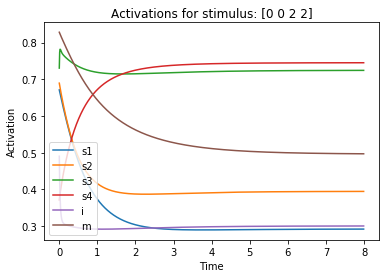

In [1042]:

dynamics = visualize_dynamics(best_agent, False, np.array([0,0,2,2]),6,9)


In [1029]:
# looking at the stimuli which were classified correctly
indices = np.equal(rewards, 1.0) 
np.unique(stimuli[indices], axis=0)

array([[0.e+00, 0.e+00, 1.e+00, 1.e+00, 1.e-03, 1.e-03],
       [0.e+00, 0.e+00, 1.e+00, 2.e+00, 1.e-03, 1.e-03],
       [0.e+00, 0.e+00, 2.e+00, 1.e+00, 1.e-03, 1.e-03],
       [0.e+00, 1.e+00, 0.e+00, 1.e+00, 1.e-03, 1.e-03],
       [0.e+00, 1.e+00, 0.e+00, 2.e+00, 1.e-03, 1.e-03],
       [0.e+00, 1.e+00, 1.e+00, 0.e+00, 1.e-03, 1.e-03],
       [0.e+00, 1.e+00, 2.e+00, 0.e+00, 1.e-03, 1.e-03],
       [0.e+00, 2.e+00, 0.e+00, 1.e+00, 1.e-03, 1.e-03],
       [0.e+00, 2.e+00, 0.e+00, 2.e+00, 1.e-03, 1.e-03],
       [0.e+00, 2.e+00, 1.e+00, 0.e+00, 1.e-03, 1.e-03],
       [1.e+00, 0.e+00, 0.e+00, 1.e+00, 1.e-03, 1.e-03],
       [1.e+00, 0.e+00, 0.e+00, 2.e+00, 1.e-03, 1.e-03],
       [1.e+00, 0.e+00, 1.e+00, 0.e+00, 1.e-03, 1.e-03],
       [1.e+00, 0.e+00, 2.e+00, 0.e+00, 1.e-03, 1.e-03],
       [1.e+00, 1.e+00, 0.e+00, 0.e+00, 1.e-03, 1.e-03],
       [1.e+00, 2.e+00, 0.e+00, 0.e+00, 1.e-03, 1.e-03],
       [2.e+00, 0.e+00, 0.e+00, 1.e+00, 1.e-03, 1.e-03],
       [2.e+00, 0.e+00, 0.e+00,

In [1030]:
# looking at the stimuli which were classified incorrectly 

indices = np.equal(rewards, 0.0) 
np.unique(stimuli[indices], axis=0)

array([[0.e+00, 0.e+00, 2.e+00, 2.e+00, 1.e-03, 1.e-03],
       [0.e+00, 2.e+00, 2.e+00, 0.e+00, 1.e-03, 1.e-03],
       [1.e+00, 2.e+00, 0.e+00, 0.e+00, 1.e-03, 1.e-03],
       [2.e+00, 0.e+00, 2.e+00, 0.e+00, 1.e-03, 1.e-03]])

In [1031]:
interpolation_test(best_agent, data[4][0], data[4][1],9)

Stimuli for interpolation test:
[1.         1.05263158 1.10526316 1.15789474 1.21052632 1.26315789
 1.31578947 1.36842105 1.42105263 1.47368421 1.52631579 1.57894737
 1.63157895 1.68421053 1.73684211 1.78947368 1.84210526 1.89473684
 1.94736842 2.        ]
Interpolation test: 0.552
[0.485, 0.515, (array([0.52621359, 0.57938144]), array([0.57052632, 0.5352381 ]), array([0.54747475, 0.55643564]), array([475, 525])), [0, 1, 0.0, 1.0, 1.0, 1, 1.0, 0.0, 1, 1.0, 0.0, 1.0, 0.0, 1, 1, 0.0, 1, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1, 0.0, 1, 1.0, 1, 1.0, 1.0, 0, 0.0, 1, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1, 1, 0, 1, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1, 1.0, 1.0, 1, 1.0, 1, 1, 1, 1, 1.0, 1.0, 1.0, 0.0, 1.0, 1, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1, 1.0, 0.0, 0.0, 1, 1.0, 0, 0.0, 1, 0.0, 1, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1, 1, 0.0, 1.0, 0.0, 0.0, 1, 1.0, 1.0, 0.0, 1.0, 1, 1, 1, 1, 0.0, 1.0, 1.0, 1, 0.0, 1, 1.0, 1, 1, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 0.0, 1.

[0.552,
 [0.485,
  0.515,
  (array([0.52621359, 0.57938144]),
   array([0.57052632, 0.5352381 ]),
   array([0.54747475, 0.55643564]),
   array([475, 525])),
  [0,
   1,
   0.0,
   1.0,
   1.0,
   1,
   1.0,
   0.0,
   1,
   1.0,
   0.0,
   1.0,
   0.0,
   1,
   1,
   0.0,
   1,
   1.0,
   1.0,
   1,
   1,
   1.0,
   1.0,
   1.0,
   1.0,
   1,
   0.0,
   1,
   1.0,
   1,
   1.0,
   1.0,
   0,
   0.0,
   1,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1,
   1,
   0,
   1,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1,
   1.0,
   1.0,
   1,
   1.0,
   1,
   1,
   1,
   1,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1,
   1.0,
   0.0,
   0.0,
   1,
   1.0,
   0,
   0.0,
   1,
   0.0,
   1,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1,
   1,
   0.0,
   1.0,
   0.0,
   0.0,
   1,
   1.0,
   1.0,
   0.0,
   1.0,
   1,
   1,
   

In [1032]:

stims_list, performance, precision_recall_f = extrapolation_test(best_agent, data[4][0], data[4][1],9)


Train stimuli: [1, 2], performance: 0.83
Stimuli: [2, 3], performance: 0.64


/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Stimuli: [3, 4], performance: 0.51
Stimuli: [4, 5], performance: 0.54
Stimuli: [5, 6], performance: 0.51
Stimuli: [6, 7], performance: 0.51
Stimuli: [7, 8], performance: 0.5
Stimuli: [8, 9], performance: 0.5
Stimuli: [9, 10], performance: 0.51
Stimuli: [10, 11], performance: 0.5
Stimuli: [11, 12], performance: 0.51
Stimuli: [12, 13], performance: 0.51
Stimuli: [13, 14], performance: 0.51
Stimuli: [14, 15], performance: 0.51
Stimuli: [15, 16], performance: 0.5
Stimuli: [16, 17], performance: 0.5
Stimuli: [17, 18], performance: 0.5
Stimuli: [18, 19], performance: 0.5
Stimuli: [19, 20], performance: 0.51
Stimuli: [20, 21], performance: 0.5
Stimuli: [21, 22], performance: 0.5


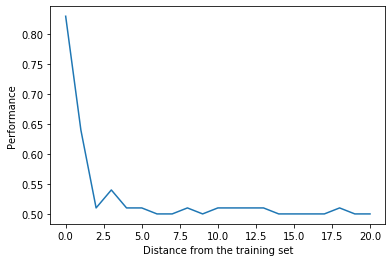

In [1033]:
plt.figure()
plt.plot(performance)
plt.xlabel('Distance from the training set')
plt.ylabel('Performance')
#plt.legend(['best fitness', 'avg. fitness'])
plt.show()

In [1035]:
rec_stimulus = reconstruction_analysis_stimulus(actions, rewards,9)

start neuron: 0, end neuron: 1, start time: 0, end time: 1, result: 0.14800000190734863
start neuron: 0, end neuron: 1, start time: 0, end time: 2, result: 0.17200005054473877
start neuron: 0, end neuron: 1, start time: 0, end time: 3, result: 0.527999997138977
start neuron: 0, end neuron: 1, start time: 0, end time: 4, result: 0.4119999408721924
start neuron: 0, end neuron: 1, start time: 0, end time: 5, result: 0.5759999752044678
start neuron: 0, end neuron: 1, start time: 0, end time: 6, result: 0.46800005435943604
start neuron: 0, end neuron: 1, start time: 0, end time: 7, result: 0.6319999694824219
start neuron: 0, end neuron: 1, start time: 1, end time: 2, result: 0.20399999618530273
start neuron: 0, end neuron: 1, start time: 1, end time: 3, result: 0.1679999828338623
start neuron: 0, end neuron: 1, start time: 1, end time: 4, result: 0.4119999408721924
start neuron: 0, end neuron: 1, start time: 1, end time: 5, result: 0.3760000467300415
start neuron: 0, end neuron: 1, start ti

start neuron: 0, end neuron: 4, start time: 1, end time: 6, result: 0.14800000190734863
start neuron: 0, end neuron: 4, start time: 1, end time: 7, result: 0.7439999580383301
start neuron: 0, end neuron: 4, start time: 2, end time: 3, result: 0.4119999408721924
start neuron: 0, end neuron: 4, start time: 2, end time: 4, result: 0.4359999895095825
start neuron: 0, end neuron: 4, start time: 2, end time: 5, result: 0.6000000238418579
start neuron: 0, end neuron: 4, start time: 2, end time: 6, result: 0.656000018119812
start neuron: 0, end neuron: 4, start time: 2, end time: 7, result: 0.7359999418258667
start neuron: 0, end neuron: 4, start time: 3, end time: 4, result: 0.13600003719329834
start neuron: 0, end neuron: 4, start time: 3, end time: 5, result: 0.38399994373321533
start neuron: 0, end neuron: 4, start time: 3, end time: 6, result: 0.6599999666213989
start neuron: 0, end neuron: 4, start time: 3, end time: 7, result: 0.7400000095367432
start neuron: 0, end neuron: 4, start tim

start neuron: 1, end neuron: 3, start time: 4, end time: 5, result: 0.4119999408721924
start neuron: 1, end neuron: 3, start time: 4, end time: 6, result: 0.3760000467300415
start neuron: 1, end neuron: 3, start time: 4, end time: 7, result: 0.6920000314712524
start neuron: 1, end neuron: 3, start time: 5, end time: 6, result: 0.2120000123977661
start neuron: 1, end neuron: 3, start time: 5, end time: 7, result: 0.531999945640564
start neuron: 1, end neuron: 3, start time: 6, end time: 7, result: 0.41600000858306885
start neuron: 1, end neuron: 4, start time: 0, end time: 1, result: 0.3559999465942383
start neuron: 1, end neuron: 4, start time: 0, end time: 2, result: 0.687999963760376
start neuron: 1, end neuron: 4, start time: 0, end time: 3, result: 0.7760000228881836
start neuron: 1, end neuron: 4, start time: 0, end time: 4, result: 0.7039999961853027
start neuron: 1, end neuron: 4, start time: 0, end time: 5, result: 0.5559999942779541
start neuron: 1, end neuron: 4, start time: 

start neuron: 2, end neuron: 4, start time: 0, end time: 6, result: 0.7120000123977661
start neuron: 2, end neuron: 4, start time: 0, end time: 7, result: 0.7960000038146973
start neuron: 2, end neuron: 4, start time: 1, end time: 2, result: 0.42799997329711914
start neuron: 2, end neuron: 4, start time: 1, end time: 3, result: 0.46800005435943604
start neuron: 2, end neuron: 4, start time: 1, end time: 4, result: 0.5880000591278076
start neuron: 2, end neuron: 4, start time: 1, end time: 5, result: 0.5199999809265137
start neuron: 2, end neuron: 4, start time: 1, end time: 6, result: 0.527999997138977
start neuron: 2, end neuron: 4, start time: 1, end time: 7, result: 0.7400000095367432
start neuron: 2, end neuron: 4, start time: 2, end time: 3, result: 0.14800000190734863
start neuron: 2, end neuron: 4, start time: 2, end time: 4, result: 0.48399996757507324
start neuron: 2, end neuron: 4, start time: 2, end time: 5, result: 0.5160000324249268
start neuron: 2, end neuron: 4, start ti

start neuron: 3, end neuron: 5, start time: 2, end time: 5, result: 0.5039999485015869
start neuron: 3, end neuron: 5, start time: 2, end time: 6, result: 0.46000003814697266
start neuron: 3, end neuron: 5, start time: 2, end time: 7, result: 0.5240000486373901
start neuron: 3, end neuron: 5, start time: 3, end time: 4, result: 0.20399999618530273
start neuron: 3, end neuron: 5, start time: 3, end time: 5, result: 0.37199997901916504
start neuron: 3, end neuron: 5, start time: 3, end time: 6, result: 0.5679999589920044
start neuron: 3, end neuron: 5, start time: 3, end time: 7, result: 0.5039999485015869
start neuron: 3, end neuron: 5, start time: 4, end time: 5, result: 0.30799996852874756
start neuron: 3, end neuron: 5, start time: 4, end time: 6, result: 0.20799994468688965
start neuron: 3, end neuron: 5, start time: 4, end time: 7, result: 0.40799999237060547
start neuron: 3, end neuron: 5, start time: 5, end time: 6, result: 0.2120000123977661
start neuron: 3, end neuron: 5, start

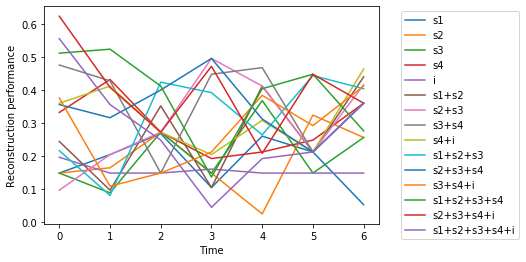

In [1036]:
visualize_reconstruction(rec_stimulus, time_max = 8)